In [1]:
import itk
from matplotlib import pyplot as plt

In [2]:
# ----------------------
# Lecture de l'image
# ----------------------
input_filename = 'data/brain.png'
image = itk.imread(input_filename)
ImageType = type(image) # On récupère le type de l'image
# ----------------------
# Création et paramétrage du filtre
# ----------------------
# On créé une instance du filtre qui prend en entrée et ressort des images du même type que l'image d'entrée
smoothFilter = itk.SmoothingRecursiveGaussianImageFilter[ImageType,ImageType].New() 
smoothFilter.SetInput(image) # On spécifie l'image d'entrée du filtre

In [3]:
sigma = 5
smoothFilter.SetSigma(sigma) # On sélectionne la variance du filtre
# ----------------------
# Écriture de la sortie du filtre
# ----------------------
# On écrit sur le disque la sortie du filtre Gaussien
itk.imwrite(smoothFilter.GetOutput(), 'output/myImage_smoothed.png') 

In [4]:
absolutFilter = itk.AbsoluteValueDifferenceImageFilter[ImageType,ImageType,ImageType].New()
absolutFilter.SetInput1(image)
absolutFilter.SetInput2(smoothFilter.GetOutput())
itk.imwrite(absolutFilter.GetOutput(), 'output/myImage_absolut.png')

### Exercice 2

In [5]:
fixed_image = itk.imread('data/BrainProtonDensitySliceBorder20.png')
moving_image = itk.imread('data/BrainProtonDensitySliceShifted13x17y.png')

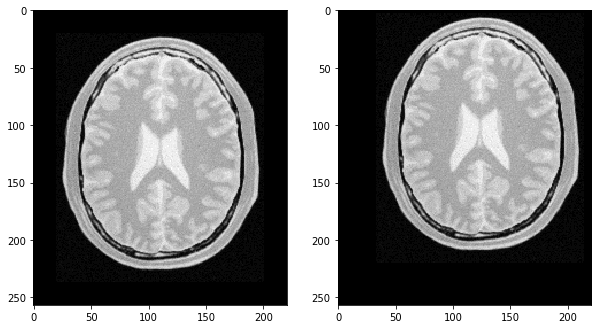

In [6]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(itk.GetArrayViewFromImage(fixed_image), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(itk.GetArrayViewFromImage(moving_image), cmap='gray')
plt.show()

In [7]:
optimizer = itk.RegularStepGradientDescentOptimizer.New() # Instance de laclasse d'optimiseur choisie
optimizer.SetMaximumStepLength(4) # Borne supérieure du pas de descente (en pixel)
optimizer.SetMinimumStepLength(0.01) # Borne inférieure du pas de descente (en pixel)
optimizer.SetNumberOfIterations(200) # Nombre maximal d'itération

In [8]:
f=[]
def getMetricValue():
    f.append(optimizer.GetValue())
optimizer.AddObserver(itk.IterationEvent(),getMetricValue)  

[]


In [9]:
initialTransform = itk.TranslationTransform[itk.D, 2].New() # Instance de la classe de transformation choisie
initialParameters = initialTransform.GetParameters() # Récupération des paramètres de la transformation
initialParameters[0] = 13.0 # Initialisation du paramètre de translation en x
initialParameters[1] = 17.0 # Initialisation du paramètre de translation en y

In [10]:
registration_filter = itk.ImageRegistrationMethod[ImageType, ImageType].New() # Instance de la classe de recalage choisie
registration_filter.SetFixedImage(fixed_image) # Image de référence
registration_filter.SetMovingImage(moving_image) # Image à recaler
registration_filter.SetOptimizer(optimizer)
registration_filter.SetTransform(initialTransform) # Transformation
registration_filter.SetInitialTransformParameters(initialParameters) # Application de la transformation initiale

registration_filter.SetInterpolator(itk.LinearInterpolateImageFunction[ImageType, itk.D].New()) # Interpolateur
registration_filter.SetMetric(itk.MeanSquaresImageToImageMetric[ImageType, ImageType].New()) # Métrique

registration_filter.Update() # Exécution du recalage

In [11]:
print(f)
# plt.figure()
# plt.plot(f)

[6867.9990184294875, 6096.397241813615, 5377.93923899747, 4678.826261264027, 3994.580021354315, 3514.621282014005, 3212.2160829680856, 2717.8633713841205, 1570.6767678650788, 176.40645166715987, 1657.4542795302323, 572.3911786799182, 178.12324484579887, 56.81720283804566, 8.554343774194718, 5.334991238720097, 0.09480499106317598, 1.0027717898488768, 0.12027452985010716, 0.09480285207550147]


In [12]:
final_transform = registration_filter.GetTransform()

In [13]:
resample_filter = itk.ResampleImageFilter[ImageType,ImageType].New() # Instance de la classe de ré-échantillonnage
resample_filter.SetInput(moving_image) # Image d'entrée
resample_filter.SetTransform(final_transform)
resample_filter.SetSize(fixed_image.GetLargestPossibleRegion().GetSize())
itk.imwrite(resample_filter.GetOutput(), 'output/image_recalee.png') # Ecriture de l'image recalée sur le disque

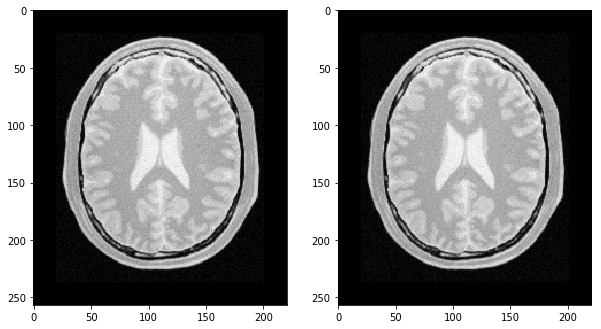

In [14]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(itk.GetArrayViewFromImage(fixed_image), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(itk.GetArrayViewFromImage(resample_filter.GetOutput()), cmap='gray')
plt.show()